# Linea Base (Regresion de Cox)

Paquetes:

In [2]:
#Utils
import h5py
import matplotlib.pyplot as plt
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#Numeric
import numpy as np

#Modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

#ownimport sys
sys.path.append('/home/jmalagont/Documentos/MLDS6project/src/nombre_paquete/training')
import survivalflow as sf

Rutas importantes:

In [3]:
DataSetPath = '/home/jmalagont/Documentos/MLDS6project/src/dataset/TCGA-BRCA.h5'

# 1. Carga de datos

In [4]:
DataSet = h5py.File(DataSetPath,'r+') 
Labels = np.abs(np.array([DataSet['time'], DataSet['status']]).T)
features = np.array(DataSet['embedding'])

X_train, X_test, Y_train, Y_test = train_test_split(features, Labels, test_size=0.3, random_state=42)

print('Entrenamiento\n==============')
print(f'{len(X_train)} Observaciones, tiempos [{np.min(Y_train[:,0])},{np.max(Y_train[:,0])}]')
print('Test\n==============')
print(f'{len(X_test)} Observaciones, tiempos [{np.min(Y_test[:,0])},{np.max(Y_test[:,0])}]')

Entrenamiento
726 Observaciones, tiempos [0,12205]
Test
312 Observaciones, tiempos [0,13132]


# 2. Modelo

In [5]:
K.clear_session()

input = Input(shape=(2048))
out = Dense(1, activation = 'linear', use_bias = False, kernel_initializer='zeros')(input)

cox = Model(inputs=[input], outputs=[out], name="cox")
cox.compile(optimizer=Adam(learning_rate=0.001), loss=sf.LogNegativePartialLikelihood,  metrics=[sf.harrell_index])
cox.summary()

Model: "cox"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense (Dense)               (None, 1)                 2048      
                                                                 
Total params: 2,048
Trainable params: 2,048
Non-trainable params: 0
_________________________________________________________________


In [6]:
ES = EarlyStopping(monitor='val_loss',restore_best_weights=True, patience = 100)
training_gen = sf.SurvivalDataGenerator(X_train, Y_train, cox, surv_path='global')
test_gen = sf.SurvivalDataGenerator(X_test, Y_test, cox, surv_path='global')

# 3. Entrenamiento

In [7]:
history = cox.fit(x = training_gen, validation_data = test_gen, epochs=100, callbacks = [ES])

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 5.1840 - harrell_index: 0.0000e+00 - val_loss: 16.6352 - val_harrell_index: 0.5728
Epoch 2/100
1/1 [==============================] - 0s 326ms/step - loss: 19.5750 - harrell_index: 0.5262 - val_loss: 7.3027 - val_harrell_index: 0.5837
Epoch 3/100
1/1 [==============================] - 0s 297ms/step - loss: 8.0101 - harrell_index: 0.5370 - val_loss: 7.9977 - val_harrell_index: 0.4660
Epoch 4/100
1/1 [==============================] - 0s 302ms/step - loss: 9.6612 - harrell_index: 0.4980 - val_loss: 8.5767 - val_harrell_index: 0.4692
Epoch 5/100
1/1 [==============================] - 0s 334ms/step - loss: 10.1029 - harrell_index: 0.4904 - val_loss: 7.6196 - val_harrell_index: 0.5148
Epoch 6/100
1/1 [==============================] - 0s 310ms/step - loss: 9.6574 - harrell_index: 0.4727 - val_loss: 7.5215 - val_harrell_index: 0.5719
Epoch 7/100
1/1 [==============================] - 0s 297ms/step - loss: 9.8625 - harrell_

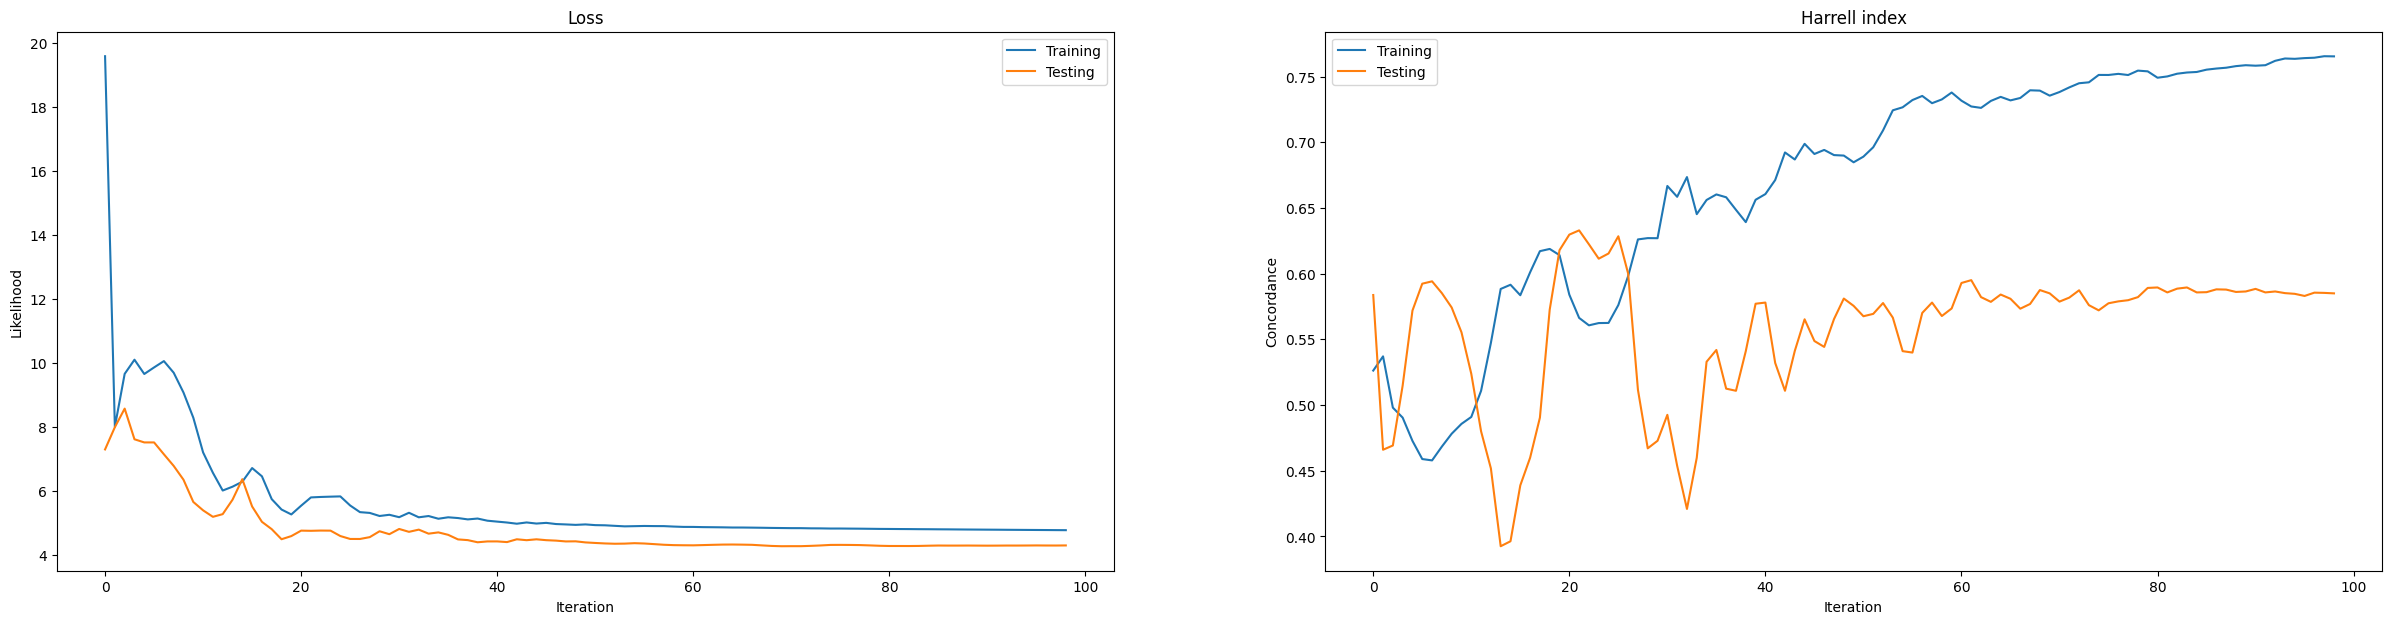

In [7]:
hs = history.history

fig, char = plt.subplots(1,2)
fig.set_size_inches(30, 7)

char[0].plot(hs['loss'][1:], label='Training')
char[0].plot(hs['val_loss'][1:], label='Testing')
char[0].set_title('Loss')
char[0].set_xlabel('Iteration')
char[0].set_ylabel('Likelihood')
char[0].legend()

char[1].plot(hs['harrell_index'][1:], label='Training')
char[1].plot(hs['val_harrell_index'][1:], label='Testing')
char[1].set_title('Harrell index')
char[1].set_xlabel('Iteration')
char[1].set_ylabel('Concordance')
char[1].legend()

plt.show()

# 4. Evaluación

In [18]:
score = cox.evaluate(test_gen, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 4.306453704833984
Test accuracy: 0.5849937200546265


2023-06-16 13:44:40.960672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
